# Using Predictive Analytics to Predict Delays in Maritime Container Shipping

In [1]:
%matplotlib inline

**Import Libraries**

In [2]:
import csv
import pandas as pd
import numpy as np
import pylab 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

#http://pythondata.com/dask-large-csv-python/
#import dask.dataframe as dd
 
#from collections import Counter
#from patsy import dmatrices
#import statsmodels.api as sm

#https://www.dataquest.io/blog/pandas-big-data/

**Read in files**

In [3]:
#open and read the file into a pandas data frame
filename = "C:\Users\Stacey\Downloads\Enigma-BillofLadingSummary-2014.csv"

In [5]:
#get headers
headers = pd.read_csv(filename, nrows = 0)
headers = list(headers)
headers

['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 'secondary_notify_party_1',
 'actual_arrival_date',
 'consignee_name',
 'consignee_address',
 'consignee_contact_name',
 'consignee_comm_number_qualifier',
 'consignee_comm_number',
 'shipper_party_name',
 'shipper_address',
 'shipper_contact_name',
 'shipper_comm_number_qualifier',
 'shipper_comm_number',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 'harmonized_number',
 'harmonized_value',
 'harmonized_weight',
 'harmonized_weight_unit']

In [6]:
#get the number of rows in the file
#get the number of rows in the file
with open(filename) as f:
    row_count = sum(1 for row in f)
    print(row_count if row_count else 'Empty')
row_count

11025608


11025608

In [13]:
#set the columns to read in
columns = ['identifier',
 'trade_update_date',
 'run_date',
 'vessel_name',
 'port_of_unlading',
 'estimated_arrival_date',
 'foreign_port_of_lading',
 'record_status_indicator',
 'place_of_receipt',
 'port_of_destination',
 'foreign_port_of_destination',
 #'secondary_notify_party_1',
 'actual_arrival_date',
 'consignee_name',
 #'consignee_address',
 #'consignee_contact_name',
 #'consignee_comm_number_qualifier',
 #'consignee_comm_number',
 'shipper_party_name',
 #'shipper_address'
 #'shipper_contact_name',
 #'shipper_comm_number_qualifier',
 #'shipper_comm_number',
 'container_number',
 'description_sequence_number',
 'piece_count',
 'description_text',
 #'harmonized_number',
 #'harmonized_value',
 #'harmonized_weight',
 #'harmonized_weight_unit'
 ]

In [14]:
#Set up datatypes
dtypes = {'identifier': 'uint64', #uint is for positive integers and more memory efficient
 'trade_update_date': 'str' ,
 'run_date': 'str',
 'vessel_name': 'str',
 'port_of_unlading':'str',
 'estimated_arrival_date':'str',
 'foreign_port_of_lading':'str',
 'record_status_indicator':'category',
 'place_of_receipt':'str',
 'port_of_destination':'str',
 'foreign_port_of_destination':'str',
 #'secondary_notify_party_1':'str',
 'actual_arrival_date':'str',
 'consignee_name':'str',
 #'consignee_address':'str',
 #'consignee_contact_name':'str',
 #'consignee_comm_number_qualifier':'str',
 #'consignee_comm_number':'str',
 'shipper_party_name':'str',
 #'shipper_address':'str',
 #'shipper_contact_name':'str',
 #'shipper_comm_number_qualifier':'str',
 #'shipper_comm_number':'str',
 'container_number':'str',
 'description_sequence_number':'uint64',
 'piece_count':'uint64',
 'description_text':'str',
 #'harmonized_number':'str',
 #'harmonized_value':'str',
 #'harmonized_weight':'str',
 #'harmonized_weight_unit':'str'
 }

In [15]:
parse_dates = ['trade_update_date',
 'run_date',
 'estimated_arrival_date',
 'actual_arrival_date',
 ]

In [16]:
#read in one section of the file
df1 = pd.read_csv(filename, nrows = 1000000, usecols = columns, dtype = dtypes, parse_dates = parse_dates)

In [17]:
#check memory usage
df1.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
identifier                     1000000 non-null uint64
trade_update_date              1000000 non-null datetime64[ns]
run_date                       1000000 non-null datetime64[ns]
vessel_name                    1000000 non-null object
port_of_unlading               999906 non-null object
estimated_arrival_date         1000000 non-null datetime64[ns]
foreign_port_of_lading         995140 non-null object
record_status_indicator        1000000 non-null category
place_of_receipt               997025 non-null object
port_of_destination            118549 non-null object
foreign_port_of_destination    13457 non-null object
actual_arrival_date            1000000 non-null datetime64[ns]
consignee_name                 874401 non-null object
shipper_party_name             854344 non-null object
container_number               999985 non-null object
description_sequence_number    1000000

** Reduce Memory Usage **  
https://www.dataquest.io/blog/pandas-big-data/  
- int and float: consider uint for positive integers and ufloat for positive, also lower than int64 if 64 isn't needed
- object: consider using category if unique values are less than 50% of all values

In [18]:
#determine which fields can be converted to less memory intensive fields
print "total records: ", len(df1)
for field in list(df1):
    print field, len(df1[field].unique()), len(df1[field].unique())/(len(df1) * 1.0)

total records:  1000000
identifier 435098 0.435098
trade_update_date 589 0.000589
run_date 297 0.000297
vessel_name 4169 0.004169
port_of_unlading 147 0.000147
estimated_arrival_date 630 0.00063
foreign_port_of_lading 702 0.000702
record_status_indicator 3 3e-06
place_of_receipt 15413 0.015413
port_of_destination 170 0.00017
foreign_port_of_destination 185 0.000185
actual_arrival_date 573 0.000573
consignee_name 124030 0.12403
shipper_party_name 144346 0.144346
container_number 627647 0.627647
description_sequence_number 484 0.000484
piece_count 9376 0.009376
description_text 423376 0.423376


Based on a subset of the data, many fields can be read in as category type, which will save memory

In [23]:
#Set up datatypes
dtypes2 = {'identifier': 'uint64', #uint is for positive integers and more memory efficient
 'trade_update_date': 'str' ,
 'run_date': 'str',
 'vessel_name': 'category',
 'port_of_unlading':'category',
 'estimated_arrival_date':'str',
 'foreign_port_of_lading':'category',
 'record_status_indicator':'category',
 'place_of_receipt':'category',
 'port_of_destination':'category',
 'foreign_port_of_destination':'category',
 #'secondary_notify_party_1':'category',
 'actual_arrival_date':'str',
 'consignee_name':'category',
 #'consignee_address':'category',
 #'consignee_contact_name':'category',
 #'consignee_comm_number_qualifier':'category',
 #'consignee_comm_number':'category',
 'shipper_party_name':'category',
 #'shipper_address':'category',
 #'shipper_contact_name':'category',
 #'shipper_comm_number_qualifier':'category',
 #'shipper_comm_number':'category',
 'container_number':'category',
 'description_sequence_number':'uint64',
 'piece_count':'uint64',
 'description_text':'category',
 #'harmonized_number':'category',
 #'harmonized_value':'category',
 #'harmonized_weight':'category',
 #'harmonized_weight_unit':'category'
 }

In [24]:
#test memory usage, but importing the same chunk of the file
df1_V2 = pd.read_csv(filename, nrows = 1000000, usecols = columns, dtype = dtypes2, parse_dates = parse_dates)

In [25]:
df1_V2.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
identifier                     1000000 non-null uint64
trade_update_date              1000000 non-null datetime64[ns]
run_date                       1000000 non-null datetime64[ns]
vessel_name                    1000000 non-null category
port_of_unlading               999906 non-null category
estimated_arrival_date         1000000 non-null datetime64[ns]
foreign_port_of_lading         995140 non-null category
record_status_indicator        1000000 non-null category
place_of_receipt               997025 non-null category
port_of_destination            118549 non-null category
foreign_port_of_destination    13457 non-null category
actual_arrival_date            1000000 non-null datetime64[ns]
consignee_name                 874401 non-null category
shipper_party_name             854344 non-null category
container_number               999985 non-null category
description_sequence

In [26]:
df1_V2.dtypes

identifier                             uint64
trade_update_date              datetime64[ns]
run_date                       datetime64[ns]
vessel_name                          category
port_of_unlading                     category
estimated_arrival_date         datetime64[ns]
foreign_port_of_lading               category
record_status_indicator              category
place_of_receipt                     category
port_of_destination                  category
foreign_port_of_destination          category
actual_arrival_date            datetime64[ns]
consignee_name                       category
shipper_party_name                   category
container_number                     category
description_sequence_number            uint64
piece_count                            uint64
description_text                     category
dtype: object

In [27]:
df1_V2.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,foreign_port_of_destination,actual_arrival_date,consignee_name,shipper_party_name,container_number,description_sequence_number,piece_count,description_text
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,NaN,2014-08-19,IKEA DISTRIBUTION SERVICES INC. - S,TIANJIN TONG SHI INDUSTRY TRADE C,TGHU8036820,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,NaN,2014-08-19,NaN,NaN,APZU3172532,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,NaN,2014-08-19,NaN,NaN,APZU3599329,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,NaN,2014-08-19,NaN,NaN,TRLU3176120,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,NaN,2014-08-20,SHEPHERD CASTER CORP,BEST HOPEFUL INDUSTRIAL DEVELOPMENT,OOLU1064780,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...


In [28]:
#try reading in the complete file now
df = pd.read_csv(filename, usecols = columns, dtype = dtypes2,  parse_dates = parse_dates)

In [30]:
#check the memory usage
df.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11025607 entries, 0 to 11025606
Data columns (total 18 columns):
identifier                     uint64
trade_update_date              datetime64[ns]
run_date                       datetime64[ns]
vessel_name                    category
port_of_unlading               category
estimated_arrival_date         datetime64[ns]
foreign_port_of_lading         category
record_status_indicator        category
place_of_receipt               category
port_of_destination            category
foreign_port_of_destination    category
actual_arrival_date            datetime64[ns]
consignee_name                 category
shipper_party_name             category
container_number               category
description_sequence_number    uint64
piece_count                    uint64
description_text               category
dtypes: category(11), datetime64[ns](4), uint64(3)
memory usage: 2.4 GB


In [31]:
#check that all rows imported
df.shape

(11025607, 18)

Looks like all but one row was imported

In [ ]:
#df2 = pd.read_csv(filename, nrows = 1000000, skiprows = list(range(1,1000000)),
#                 dtype = dtypes, parse_dates = parse_dates)

In [ ]:
#df = df1
#df = df.append(df2)
#df = df.append(df3)
#df = df.append(df4)
#df = df.append(df5)
#df = df.append(df6)
#df = df.append(df7)
#df = df.append(df8)
#df = df.append(df9)
#df = df.append(df10)
#df = df.append(df11)

#len(df)

In [32]:
df.dtypes

identifier                             uint64
trade_update_date              datetime64[ns]
run_date                       datetime64[ns]
vessel_name                          category
port_of_unlading                     category
estimated_arrival_date         datetime64[ns]
foreign_port_of_lading               category
record_status_indicator              category
place_of_receipt                     category
port_of_destination                  category
foreign_port_of_destination          category
actual_arrival_date            datetime64[ns]
consignee_name                       category
shipper_party_name                   category
container_number                     category
description_sequence_number            uint64
piece_count                            uint64
description_text                     category
dtype: object

In [36]:
#record status types
df.record_status_indicator.unique()

[New, Amended, Deleted]
Categories (3, object): [New, Amended, Deleted]

In [37]:
#remove deleted records
df = df[df.record_status_indicator != 'Deleted']

In [38]:
df.shape

(10816209, 18)

In [41]:
#get the company from the vessel name (first word) - will need to research this, probably doesn't always apply
df['carrier'] = df.vessel_name.str.split().str[0].astype('category')

In [43]:
df['carrier'].unique()

[HYUNDAI, OOCL, COSCO, MSC, NAGOYA, ..., BOSTSWANA, MORSTON, HAMBURG, FLAG, EVERBRIGHT]
Length: 3735
Categories (3735, object): [HYUNDAI, OOCL, COSCO, MSC, ..., MORSTON, HAMBURG, FLAG, EVERBRIGHT]

In [44]:
#Get day of week DatetimeIndex.dayofweek
#The day of the week with Monday=0, Sunday=6
df['day_of_week_est'] = df.estimated_arrival_date.dt.dayofweek 
df['day_of_week_act'] = df.actual_arrival_date.dt.dayofweek

In [45]:
df.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,actual_arrival_date,consignee_name,shipper_party_name,container_number,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,2014-08-19,IKEA DISTRIBUTION SERVICES INC. - S,TIANJIN TONG SHI INDUSTRY TRADE C,TGHU8036820,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...,HYUNDAI,3,1
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,2014-08-19,NaN,NaN,APZU3172532,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,2014-08-19,NaN,NaN,APZU3599329,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,2014-08-19,NaN,NaN,TRLU3176120,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,...,2014-08-20,SHEPHERD CASTER CORP,BEST HOPEFUL INDUSTRIAL DEVELOPMENT,OOLU1064780,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...,OOCL,1,2


In [46]:
#get the month
df['month_est'] = df.estimated_arrival_date.dt.month
df['month_act'] = df.actual_arrival_date.dt.month

In [47]:
df.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,shipper_party_name,container_number,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,TIANJIN TONG SHI INDUSTRY TRADE C,TGHU8036820,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...,HYUNDAI,3,1,8,8
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,NaN,APZU3172532,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,NaN,APZU3599329,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,NaN,TRLU3176120,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,...,BEST HOPEFUL INDUSTRIAL DEVELOPMENT,OOLU1064780,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...,OOCL,1,2,8,8


In [48]:
#set up a number of days delayed column actual vs estimated
df['delay_days'] = (df['actual_arrival_date'] - df['estimated_arrival_date']).dt.days

In [49]:
df.head()

,identifier,trade_update_date,run_date,vessel_name,port_of_unlading,estimated_arrival_date,foreign_port_of_lading,record_status_indicator,place_of_receipt,port_of_destination,...,container_number,description_sequence_number,piece_count,description_text,carrier,day_of_week_est,day_of_week_act,month_est,month_act,delay_days
0,2014082158845,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,TGHU8036820,1,7881,IKEA HOME FURNISHING PRODUCTS TARIFF NUMBER 44...,HYUNDAI,3,1,8,8,5
1,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,APZU3172532,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
2,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,APZU3599329,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
3,2014082158905,2014-07-30,2014-08-21,HYUNDAI FORCE,"Seattle, Washington",2014-08-14,"Pusan,South Korea",New,"XINGANG, PC",NaN,...,TRLU3176120,1,80,KLA-GARD PACKED ON 60 PALLETS -DRILLING MUD AD...,HYUNDAI,3,1,8,8,5
4,2014082158983,2014-08-06,2014-08-21,OOCL SHENZHEN,"Long Beach, California",2014-08-19,"Yantian,China (Mainland)",New,"YANTIAN,CHINA",NaN,...,OOLU1064780,1,498,P.O.NO.050803/050938/051058/051197/051345/051 ...,OOCL,1,2,8,8,1


In [ ]:
#df.describe()

** Port of Unlading Volume **

In [60]:
#get the number of unique identifiers by U.S. port by day
ports_by_day = df[['port_of_unlading','actual_arrival_date','identifier']].groupby(['port_of_unlading','actual_arrival_date'], as_index=False).count()

In [68]:
ports_by_day.sort_values(by='identifier', ascending = False).head()

,port_of_unlading,actual_arrival_date,identifier
83978,"Los Angeles, California",2014-08-11,145044.0
146876,"Seattle, Washington",2014-01-31,54925.0
83974,"Los Angeles, California",2014-08-07,46433.0
102012,"New York/Newark Area, Newark, New Jersey",2014-01-31,43948.0
81871,"Long Beach, California",2014-08-07,42574.0


In [69]:
#get the average daily records by U.S. port
ports_avg_by_day = ports_by_day[['port_of_unlading','actual_arrival_date','identifier']].groupby(['port_of_unlading'],as_index=False).mean()

In [70]:
#change the name of the column
ports_avg_by_day.rename(index=str, columns={'identifier': 'avg _daily_records'},inplace = True)
#sort the ports by avg number of daily records
ports_avg_by_day.sort_values(by = 'avg _daily_records', ascending = False, inplace = True)

In [71]:
#alternative groupby formula
#list(df['actual_arrival_date','identifier'].groupby(df['port_of_unlading']))

In [102]:
#Top 10 ports by average daily records
#http://www.logisticsmgmt.com/article/top_30_u.s._ports_2017_preparing_for_the_uncertain
ports_avg_by_day.head(10)

,port_of_unlading,avg _daily_records
119,"Los Angeles, California",3903.494186
116,"Long Beach, California",3531.357447
145,"New York/Newark Area, Newark, New Jersey",2359.496881
219,"Tacoma, Washington",2111.092417
97,"Houston, Texas",1526.970183
206,"Savannah, Georgia",1438.495327
144,"New York, New York",1238.795745
30,"Charleston, South Carolina",1174.021097
209,"Seattle, Washington",1104.350711
151,"Norfolk, Virginia",982.334802


In [74]:
#Create a list of top 5 ports
ports_top_5 = ports_avg_by_day.head(5)['port_of_unlading'].tolist()

In [75]:
ports_top_5

['Los Angeles, California',
 'Long Beach, California',
 'New York/Newark Area, Newark, New Jersey',
 'Tacoma, Washington',
 'Houston, Texas']

** Foreign port of unlading volume**

In [80]:
df.foreign_port_of_lading.sort_values()

10105761    Aabenraa,Denmark
9820528      Aalborg,Denmark
4487824      Aalborg,Denmark
1727940      Aalesund,Norway
2772627      Aalesund,Norway
8203061       Aarhus,Denmark
1306776       Aarhus,Denmark
10982895      Aarhus,Denmark
9487041       Aarhus,Denmark
8567369       Aarhus,Denmark
7054997       Aarhus,Denmark
7054998       Aarhus,Denmark
8782461       Aarhus,Denmark
8782460       Aarhus,Denmark
5312104       Aarhus,Denmark
6937194       Aarhus,Denmark
6319594       Aarhus,Denmark
6319593       Aarhus,Denmark
6319592       Aarhus,Denmark
3651442       Aarhus,Denmark
8724649       Aarhus,Denmark
5133766       Aarhus,Denmark
2063009       Aarhus,Denmark
8724650       Aarhus,Denmark
10691201      Aarhus,Denmark
1218265       Aarhus,Denmark
5312105       Aarhus,Denmark
8791338       Aarhus,Denmark
10346191      Aarhus,Denmark
3065246       Aarhus,Denmark
                  ...       
11022237                 NaN
11022238                 NaN
11022239                 NaN
11022240      

In [77]:
foreign_ports_by_day = df[['foreign_port_of_lading','actual_arrival_date','identifier']].groupby(['foreign_port_of_lading','actual_arrival_date'],as_index = False).count()

UnicodeDecodeError: 'ascii' codec can't decode byte 0xc2 in position 4: ordinal not in range(128)

In [ ]:
foreign_ports_avg_by_day = foreign_ports_by_day.groupby(['foreign_port_of_lading'],as_index = False).mean().sort_values(by = 'identifier', ascending=False)
foreign_ports_avg_by_day.rename(index=str, columns={'identifier': 'avg _daily_records'},inplace = True)
foreign_ports_avg_by_day.head()

In [ ]:
foreign_ports_top_5 = foreign_ports_avg_by_day.head(5)['foreign_port_of_lading'].tolist()

** Analysis of Port Delays **

delay distribution: number of arrivals 1,2,3, days late or early
- trend by port: delay distribution for each U.S. port over the time period
- trend by day: delay distribution each day for all ports
- trend by day of week: delay distribution each day of the week for all ports
- delay distribution by foreign port of lading
- delay distribution by vessel_name
- delay distribution by carrier

options:
- Group carriers by size (need industry info to inform this)
- Group ports by size (need industry info to inform this)
- Limit to just the top 10 U.S. ports
- Limit to the top 10 carriers


In [81]:
#Set up the delay dataframe
delays = df[['identifier','vessel_name','carrier','container_number',
             'estimated_arrival_date','actual_arrival_date','delay_days',
             'foreign_port_of_lading','port_of_unlading',
             'day_of_week_est','day_of_week_act','month_est','month_act']]

In [82]:
#Delay distribution for top 5 U.S. ports (by avg daily records) over the time period
delays_top_5 = delays[delays['port_of_unlading'].isin(ports_top_5)]
delays_top_5.head()

,identifier,vessel_name,carrier,container_number,estimated_arrival_date,actual_arrival_date,delay_days,foreign_port_of_lading,port_of_unlading,day_of_week_est,day_of_week_act,month_est,month_act
4,2014082158983,OOCL SHENZHEN,OOCL,OOLU1064780,2014-08-19,2014-08-20,1,"Yantian,China (Mainland)","Long Beach, California",1,2,8,8
5,2014082159121,HYUNDAI GLOBAL,HYUNDAI,OOLU6442012,2014-08-18,2014-08-20,2,"Kaohsiung,China (Taiwan)","Tacoma, Washington",0,2,8,8
6,2014082159129,HYUNDAI GLOBAL,HYUNDAI,OOLU7961521,2014-08-18,2014-08-20,2,"Kaohsiung,China (Taiwan)","Tacoma, Washington",0,2,8,8
7,2014082159222,COSCO HARMONY,COSCO,HJCU2034255,2014-08-19,2014-08-19,0,"Xiamen,China (Mainland)","Los Angeles, California",1,1,8,8
8,2014082159239,COSCO HARMONY,COSCO,CXDU1724254,2014-08-19,2014-08-19,0,"Xiamen,China (Mainland)","Los Angeles, California",1,1,8,8


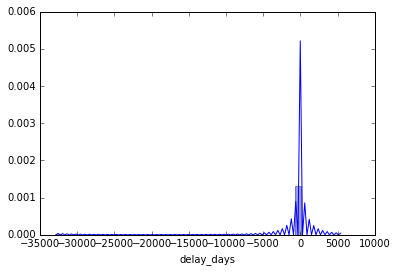

In [83]:
#View the distribution for the top 5 ports
sns.distplot(delays_top_5.delay_days)

In [84]:
#order ascending by delay
delays_top_5.sort_values(by = 'delay_days')

,identifier,vessel_name,carrier,container_number,estimated_arrival_date,actual_arrival_date,delay_days,foreign_port_of_lading,port_of_unlading,day_of_week_est,day_of_week_act,month_est,month_act
8269129,2014020457241,RJ PFEIFFER,RJ,MATU2150622,2104-02-02,2014-02-03,-32870,"Shanghai ,China (Mainland)","Long Beach, California",5,0,2,2
10521237,2014120240024,BEAR MOUNTAIN BRIDGE,BEAR,GESU4830947,2032-11-01,2014-11-29,-6547,"Hong Kong,Hong Kong","Long Beach, California",0,5,11,11
10521238,2014120240024,BEAR MOUNTAIN BRIDGE,BEAR,WHLU5510121,2032-11-01,2014-11-29,-6547,"Hong Kong,Hong Kong","Long Beach, California",0,5,11,11
10521239,2014120240024,BEAR MOUNTAIN BRIDGE,BEAR,WHLU5578939,2032-11-01,2014-11-29,-6547,"Hong Kong,Hong Kong","Long Beach, California",0,5,11,11
10236128,2014120240062,BEAR MOUNTAIN BRIDGE,BEAR,WHLU6020216,2032-11-01,2014-11-29,-6547,"Hong Kong,Hong Kong","Long Beach, California",0,5,11,11
10236127,2014120240062,BEAR MOUNTAIN BRIDGE,BEAR,WHLU4258530,2032-11-01,2014-11-29,-6547,"Hong Kong,Hong Kong","Long Beach, California",0,5,11,11
10236126,2014120240062,BEAR MOUNTAIN BRIDGE,BEAR,TCNU9650281,2032-11-01,2014-11-29,-6547,"Hong Kong,Hong Kong","Long Beach, California",0,5,11,11
10236125,2014120240062,BEAR MOUNTAIN BRIDGE,BEAR,TCNU4705268,2032-11-01,2014-11-29,-6547,"Hong Kong,Hong Kong","Long Beach, California",0,5,11,11
7291256,2014081939395,HANJIN SPAIN,HANJIN,CAIU2753617,2030-08-30,2014-08-17,-5857,"Shanghai ,China (Mainland)","Long Beach, California",4,6,8,8
5411982,201402113770,DRESDEN EXPRESS,DRESDEN,NYKU4444506,2024-01-31,2014-02-09,-3643,"Stadersand,Federal Republic of Germany","Los Angeles, California",2,6,1,2


** Evaluate Outliers**
The estimated arrival dates appear to be wrong in a some cases, especially where estimated arrival dates in 2014 are several years into the future (2018)  
Let's evaluate the number of observations where the expected arrival date is more than 30 days different from the actual arrival date  

In [85]:
#Number of observations with arrivals greater than 30 days early or late
print round((len(delays[delays.delay_days > 30]) + len(delays[delays.delay_days < -30])) / (len(delays) * 1.0),4)
#Number of observations with arrivals greater than 10 days early or late
print round((len(delays[delays.delay_days > 10]) + len(delays[delays.delay_days < -30])) / (len(delays) * 1.0),4)

0.0058
0.024


- Less than 1% of observations are greater than 30 days early or late. This research will assume that these are data entry errors and will be removed from the dataset 
- About 2% (2.4% - 0.6%) of observations are greater than 10 days early or late

In [86]:
delays = delays[(delays.delay_days > -30) & (delays.delay_days < 30)]

In [87]:
delays.head()

,identifier,vessel_name,carrier,container_number,estimated_arrival_date,actual_arrival_date,delay_days,foreign_port_of_lading,port_of_unlading,day_of_week_est,day_of_week_act,month_est,month_act
0,2014082158845,HYUNDAI FORCE,HYUNDAI,TGHU8036820,2014-08-14,2014-08-19,5,"Pusan,South Korea","Seattle, Washington",3,1,8,8
1,2014082158905,HYUNDAI FORCE,HYUNDAI,APZU3172532,2014-08-14,2014-08-19,5,"Pusan,South Korea","Seattle, Washington",3,1,8,8
2,2014082158905,HYUNDAI FORCE,HYUNDAI,APZU3599329,2014-08-14,2014-08-19,5,"Pusan,South Korea","Seattle, Washington",3,1,8,8
3,2014082158905,HYUNDAI FORCE,HYUNDAI,TRLU3176120,2014-08-14,2014-08-19,5,"Pusan,South Korea","Seattle, Washington",3,1,8,8
4,2014082158983,OOCL SHENZHEN,OOCL,OOLU1064780,2014-08-19,2014-08-20,1,"Yantian,China (Mainland)","Long Beach, California",1,2,8,8


In [88]:
#Delay distribution for top 5 U.S. ports (by avg daily records) over the time period
delays_top_5 = delays[delays['port_of_unlading'].isin(ports_top_5)]
delays_top_5.head()

,identifier,vessel_name,carrier,container_number,estimated_arrival_date,actual_arrival_date,delay_days,foreign_port_of_lading,port_of_unlading,day_of_week_est,day_of_week_act,month_est,month_act
4,2014082158983,OOCL SHENZHEN,OOCL,OOLU1064780,2014-08-19,2014-08-20,1,"Yantian,China (Mainland)","Long Beach, California",1,2,8,8
5,2014082159121,HYUNDAI GLOBAL,HYUNDAI,OOLU6442012,2014-08-18,2014-08-20,2,"Kaohsiung,China (Taiwan)","Tacoma, Washington",0,2,8,8
6,2014082159129,HYUNDAI GLOBAL,HYUNDAI,OOLU7961521,2014-08-18,2014-08-20,2,"Kaohsiung,China (Taiwan)","Tacoma, Washington",0,2,8,8
7,2014082159222,COSCO HARMONY,COSCO,HJCU2034255,2014-08-19,2014-08-19,0,"Xiamen,China (Mainland)","Los Angeles, California",1,1,8,8
8,2014082159239,COSCO HARMONY,COSCO,CXDU1724254,2014-08-19,2014-08-19,0,"Xiamen,China (Mainland)","Los Angeles, California",1,1,8,8


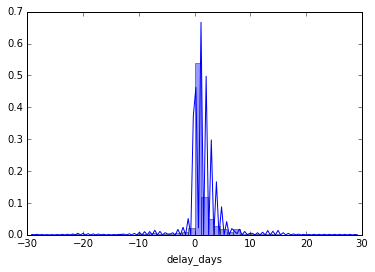

In [89]:
#Delay distribution for top 5 U.S. ports
sns.distplot(delays_top_5.delay_days)

In [90]:
#Delay distribution for top 5 U.S. ports (by avg daily records) over the time period
delays_foreign_top_5 = delays[delays['foreign_port_of_lading'].isin(foreign_ports_top_5)]
delays_foreign_top_5.head()

NameError: name 'foreign_ports_top_5' is not defined

In [91]:
v = sns.violinplot(x= 'foreign_port_of_lading',y='delay_days',
              data = delays_foreign_top_5)
v.set_xticklabels(v.get_xticklabels(),rotation=60)

NameError: name 'delays_foreign_top_5' is not defined

** Trend by Day of Week **

In [92]:
#Set up day of week color palatte
day_colors = ['#78C850', # Monday
              '#F08030', # Tuesday
              '#6890F0', # Wednesday
              '#A8B820', # Thursday
              '#A8A878', # Friday
              '#A040A0', # Saturday
              '#F8D030', # Sunday
             ]

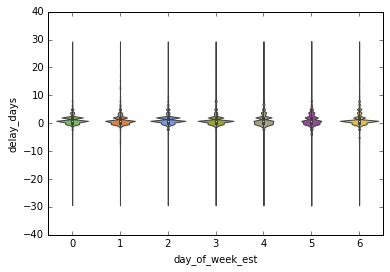

In [93]:
#Create violin plot of day of week (estimated) distribution
sns.violinplot(x='day_of_week_est',y='delay_days',
               data=delays, palette = day_colors)

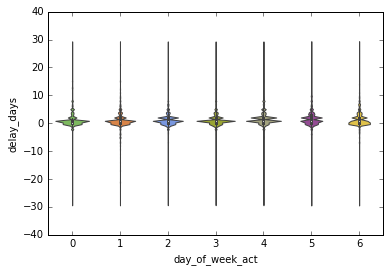

In [94]:
#Create violin plot of day of week (actual) distribution
sns.violinplot(x='day_of_week_act',y='delay_days',
              data = delays, palette = day_colors)

In [95]:
#subset data to between +/- 10 days of arrival to better see distribution
delays_10 = delays[(delays.delay_days < 10) & (delays.delay_days > -10)]

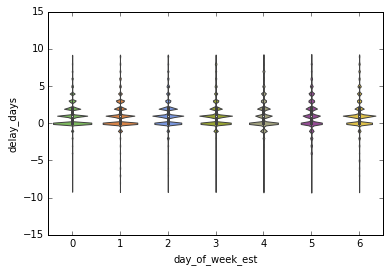

In [96]:
#view violin plot for actuals
sns.violinplot(x='day_of_week_est', y='delay_days',
              data = delays_10, palette = day_colors)

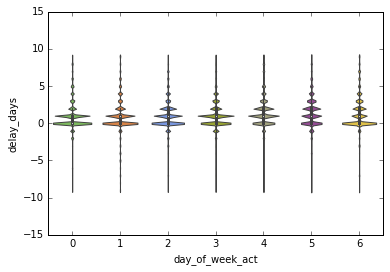

In [97]:
#view violin plot for actuals
sns.violinplot(x='day_of_week_act', y='delay_days',
              data = delays_10, palette = day_colors)

** Trend by month **

In [98]:
#Set up month color palatte
month_colors = ['#78C850', # January
              '#F08030', # February
              '#6890F0', # March
              '#A8B820', # April
              '#A8A878', # May
              '#A040A0', # June
              '#F8D030', # July
              '#E0C068', # August
              '#EE99AC', # September
              '#C03028', # October
              '#F85888', # November
              '#B8A038', # December
             ]

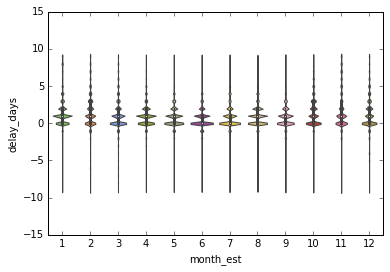

In [99]:
#create violin plot by month for actual
sns.violinplot(x='month_est',y='delay_days',
              data = delays_10, palette = month_colors)

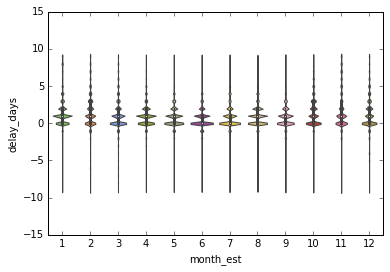

In [100]:
#create a violin plot by month for actual
sns.violinplot(x='month_est', y='delay_days',
              data = delays_10, palette = month_colors)